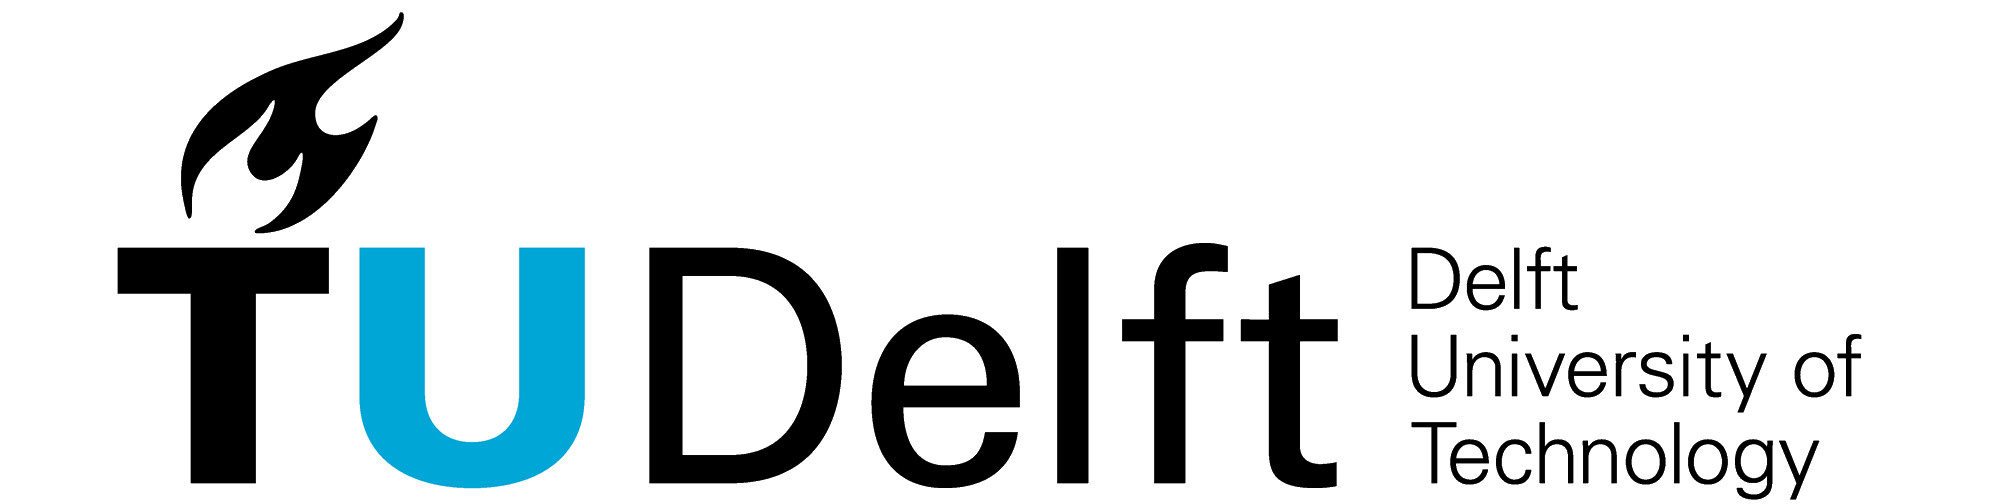

# Assignment 4 - ML Ethical and Societal perspective
Week 4 - CS4305TU Applied Machine Learning <br>

By <b> Nadia Metoui </b> and <b> Ibo van de Poel </b><br>
Faculty of Technology, Policy, and Management (TPM)

***Submission Instructions***
 - Answer the questions (code or text) in this Notebook 
 - Rename the Notebook by adding your group number
 - Send the your answers both in ipynb and HTML format

<H2>Part I: Socio-technical abstraction of an ML-based system</H2>
<i>LO-1: Identify and analyse ethical issues related to ML.<i><br>
<i>LO-2: Discuss machine learning fairness in the broader context of sociotechnical systems.</i>

Q1: Analyse and discuss the potential harmes of an ML-based Recommendation System using the Taxonomy and Model of Milan et <i>al.</i> (2020).
To help with your analysis we provide 3 case studies you can find in Brightspace
- Tiktok recommendation systems (See Case Study 1)
- Youtube recommendation systems (See Case Study 2)
- Tinder recommendation systems (See Case Study 3)

Choose <b>one of the  Case Studies</b> above and answer the following questions based on your knowledge of the platform and the information you read on the case study:
- a) Briefly summarise, what seems to be the ethical/social issue tackled in the use case you selected. 
- b) Who are the stakeholdes in this case? Name and describe at lease one stakeholdes from each category? 
- c) Briefly explain what are the intrests of each stakeholde and value they derive from using the recommendation system.
- d) Briefly explain what are the potential harmes for each stakeholde and how are they impacting them?

<div class="alert alert-block alert-info">
<b>Tip:</b> Consider all stakholders depicted in the figure below. Use the categorization of (Milano 2020).<br>
The full paper as well as a cheatsheet can be found in Brightspace.
</div>

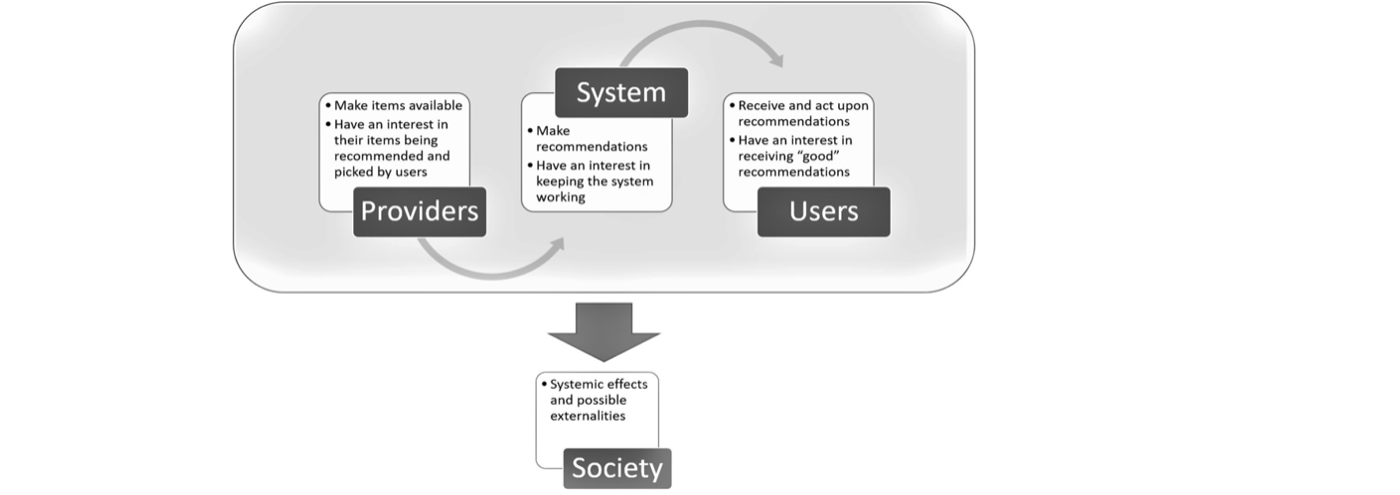

<div class="alert alert-block alert-info">
    
<b>Types of Harm</b>
- <u>on Utility</u>: Utility is the value each party is expecting to derive from using a the ML-based system. The impact or harm to Utility can be assessed using quantifiable metrics (e.g., time, money)
- <u>on Rights</u>: legal, social, or ethical entitlements (e.g., privacy autonomy, equality)  The impact or harm to Ritghts is very hard to quantify.

<br>

<b>Types of Impacts</b>
- <u>Immediate harm</u>: the recommendation or the ML-based system has an immediate and direct negative impact e.g., errors (incorrect outputs), out of context results (inappropriate outputs), opacity (uninterpretabel output).
- <u>Exposure to Risk</u>: the recommendation or the ML-based system exposes the Stakeholder(s) to latent or potential negative impacts. Even if these impacts do not materialize, exposure to such risks is considered unethical.
</div>

-  Write your answers here you are free to add other cells if needed

<br><br>

<H2> Part II. Detecting and Mitigating bias*.</H2>
<i>LO-3: Apply state-of-the-art debiasing approaches to identify and mitigate risks of biases in your ML-based system.</i><br>
<i>LO-4. Compare different implementations of fairness metrics and unfairness mitigation approaches.  
</i>

*Acknowledgement: Part II of this assignment is largely based on the code developed by <i><b>Agathe Balayn</b></i> and <i><b>Seda Gürses</b></i>

In this part of the assignment, you will be exploring a use case where a Bank wants to develop an ML-based ADM (automate decision system) to decide whether to <b>grant</b> or <b>not to grant</b> a loan to a given applicant. To do so the Bank uses historical data containing multiple application records, characterized by information about the loan applicants (e.g., age, gender, personal situation) and information about the loan (e.g., amount, duration, purpose). Each application is labeled <i> good credit </i> if the loan had been reimbursed or <i>bad credit</i> if the loan has not been reimbursed or if there where several issues with the reimbursement.

To simulate this scenario we will build a classifier to disinguich between good and bad loans (or credits). We will train the classifier using the <i><b>German credit data</b></i> (you can information about the dataset and its attributes here: (https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc).<br>
And you can download the dataset here:
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data<br>


You will be requested to take a closer look at the data and identify biases. We will use some tools form <i><b>AIF360 toolkit</b></i><br>(https://aif360.mybluemix.net/) a toolkit developed by IBM to detect and mitigate "bias" and "unfairness".

Steps of Part II
- Step 1: Set-up (Provided)
- Step 2: Explore and familiarize with the dataset
- Step 3: Pre-processing Biases: Protected attributes, proxies, data representation and skews  
- Step 4: In-processing Biases: Identify and Mitigate

<H3>Setp 2: Set-up</H3>

You first need to install the required libraries for this part.  The main libraries are the `aif360`,  `lime`, and`sklearn` ones. We also recommend using `numpy` and `pandas` to easily manipulate and explore the data.

<div class="alert alert-block alert-danger">
<b>Note:</b> Uncomment and run the next cell if you have not previously installed the libraries.
</div>


<b>Installing required libraries</b>

In [1]:
# !pip install aif360
# !pip install fairlearn
# !pip install tensorflow
# !pip install lime

<b>Loading required libraries</b>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.datasets.lime_encoder import LimeEncoder

import lime
import lime.lime_tabular

<b>Loading the dataset</b>

Here, we will load the <i><b>German credit data</b></i> in a format that is compatible with the use of the <i><b>AIF360 toolkit</b></i>. For this, you need to make use of the already implemented class of the toolkit `GermanDataset()`.

Because the data available is encoded in a complex way, we provide you with the code to preprocess it, in the function `custom_preprocessing()`. We also provide you with an example on how to actually load the data using the `GermanDataset()` class, in `preproc_and_load_data_german()`. 

In [3]:
def preproc_and_load_data_german():
    """
    Load and pre-process german credit dataset.
    Args: -
    Returns:
        GermanDataset: An instance of GermanDataset with required pre-processing.
    """
    def custom_preprocessing(df):
        """ Custom pre-processing for German Credit Data
        """

        def group_credit_hist(x):
            if x in ['A30', 'A31', 'A32']:
                return 'None/Paid'
            elif x == 'A33':
                return 'Delay'
            elif x == 'A34':
                return 'Other'
            else:
                return 'NA'

        def group_employ(x):
            if x == 'A71':
                return 'Unemployed'
            elif x in ['A72', 'A73']:
                return '1-4 years'
            elif x in ['A74', 'A75']:
                return '4+ years'
            else:
                return 'NA'

        def group_savings(x):
            if x in ['A61', 'A62']:
                return '<500'
            elif x in ['A63', 'A64']:
                return '500+'
            elif x == 'A65':
                return 'Unknown/None'
            else:
                return 'NA'

        def group_status(x):
            if x in ['A11', 'A12']:
                return '<200'
            elif x in ['A13']:
                return '200+'
            elif x == 'A14':
                return 'None'
            else:
                return 'NA'
        
        def group_personal_status(x):
            if x in ['A91']:
                return 'divorced/separated'
            elif x in ['A92']:
                return 'divorced/separated/married'
            elif x in ['A93', 'A95']:
                return 'single'
            elif x in ['A94']:
                return 'married/widowed'
            else:
                return 'NA'
        #print(df)
        #print(df.shape)
        #print(df.isnull().sum().sum())
        #print(df.isin(['NA']).sum(axis=0))
        status_map = {'A91': 1.0, 'A93': 1.0, 'A94': 1.0,
                    'A92': 0.0, 'A95': 0.0}
        
        df['sex'] = df['personal_status'].replace(status_map)
        

        # group credit history, savings, and employment
        df['credit_history'] = df['credit_history'].apply(lambda x: group_credit_hist(x))
        df['savings'] = df['savings'].apply(lambda x: group_savings(x))
        df['employment'] = df['employment'].apply(lambda x: group_employ(x))
        #df['age'] = df['age'].apply(lambda x: np.float(x >= 26))
        df['status'] = df['status'].apply(lambda x: group_status(x))
        df['personal_status'] = df['personal_status'].apply(lambda x: group_personal_status(x))
        #print(df.isin(['NA']).sum(axis=0))
        
        print(df)
        df.to_csv("german_credit_data_processed_v2.csv")
        return df

    # Feature partitions
    XD_features = ['number_of_credits', 'telephone',
                     'foreign_worker', 'people_liable_for', 'skill_level', 'credit_history', 'installment_plans', 'residence_since', 'property', 'other_debtors', 'purpose', 'savings', 'employment', 'sex', 'age', 'personal_status', 'month']
    D_features = ['sex', 'age'] 
    Y_features = ['credit']
    X_features = list(set(XD_features)-set(D_features))
    categorical_features = ['installment_plans', 'telephone',
                     'foreign_worker', 'skill_level', 'credit_history', 'property', 
                            'other_debtors', 'purpose', 'savings', 'employment', 'personal_status']

    # privileged classes
    all_privileged_classes = {"sex": [1.0],
                              "age": lambda x: x > 25}

    # protected attribute maps
    all_protected_attribute_maps = {"sex": {1.0: 'Male', 0.0: 'Female'},
                                    "age": {1.0: 'Old', 0.0: 'Young'}}

    return GermanDataset(
        label_name=Y_features[0],
        favorable_classes=[1],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        categorical_features=categorical_features,
        features_to_keep=X_features+Y_features+D_features,
        features_to_drop=[],
        metadata={ 'label_maps': [{1.0: 'Good Credit', 2.0: 'Bad Credit'}],
                   'protected_attribute_maps': [all_protected_attribute_maps[x]
                                for x in D_features]},
        custom_preprocessing=custom_preprocessing)

<br><br>

<H3>Step 2: Explore and familiarize with the dataset</H3>

<b>Q1: Analyse the dataset and answer the following:</b> 
- What is the number of records, 
- What is the number of attributes present with the preprocessing we provided, and 
- What is the list of attribute names.
- Are there missing values that could create biases

<div class="alert alert-block alert-danger">
<b>Note:</b> If you encounted any errors in the following cell add the files "german.doc" and "german.data" to the folder <br>
"dist-packages/aif360/data/raw/german/" under your python path you should get the same instructions in the error message.

You can find the files in Brightspace or download them from: <br>
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data<br>
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
    </div>

In [4]:
# Instanciating the German credit dataset
dataset_gcredit = preproc_and_load_data_german()

    status  month credit_history purpose  credit_amount       savings  \
0     <200      6          Other     A43           1169  Unknown/None   
1     <200     48      None/Paid     A43           5951          <500   
2     None     12          Other     A46           2096          <500   
3     <200     42      None/Paid     A42           7882          <500   
4     <200     24          Delay     A40           4870          <500   
..     ...    ...            ...     ...            ...           ...   
995   None     12      None/Paid     A42           1736          <500   
996   <200     30      None/Paid     A41           3857          <500   
997   None     12      None/Paid     A43            804          <500   
998   <200     45      None/Paid     A43           1845          <500   
999   <200     45          Other     A41           4576          <500   

     employment  investment_as_income_percentage             personal_status  \
0      4+ years                            

<div class="alert alert-block alert-info">
<b>Tip:</b> The documentation of "AIF360 - German credit data" dataset  can be found <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.GermanDataset.html">[HERE]</a>. 


Take a look at documentation of AIF360 and use existing methods to explore the dataset instance how to access the features with:<br> `dataset_gcredit.features`. 

You are also free to transform the dataset into a pandas dataframe to extract the needed information.
Use <br>
    `pd_gdata = pd.DataFrame(dataset_gcredit.features, columns=dataset_gcredit.feature_names)` <br>
    to create the pandas dataframe
</div> 

- 

In [5]:
### Answer by writing the code in this cell (or create more cells if needed):###
pd_gdata = pd.DataFrame(dataset_gcredit.features, columns=dataset_gcredit.feature_names)

# Number of records:
print(f'There are {len(dataset_gcredit.features)} records\n')

# Number of features:
decoded_feature_names = set([dataset_gcredit.feature_names[i].split('=')[0] for i in range(len(dataset_gcredit.feature_names)) ])    # obtain feature in front of '=' sign
print(f'There are {len(decoded_feature_names)} unique features')
print(f'There are {len(dataset_gcredit.feature_names)} features when including all seperate one-hot encoded features\n')

# Feature names:
print(f'The names of the unique features are: {decoded_feature_names}')
print(f'All one-hot encoded features are: {dataset_gcredit.feature_names}\n')

# Number of missing values for each attribute
print(f"There are {pd_gdata.isin(['NA']).sum().sum()} nan values in total:\n")
print(pd_gdata.isin(['NA']).sum(axis=0))


There are 1000 records

There are 17 unique features
There are 47 features when including all seperate one-hot encoded features

The names of the unique features are: {'sex', 'number_of_credits', 'other_debtors', 'skill_level', 'month', 'telephone', 'savings', 'installment_plans', 'foreign_worker', 'residence_since', 'property', 'age', 'employment', 'people_liable_for', 'purpose', 'credit_history', 'personal_status'}
All one-hot encoded features are: ['month', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed', 'personal_status=divorced/separated', 'personal_status=divorced/separated/married', 'personal_status=marr

<br><br>

<H3>Step 3: Identify protected attributes and proxies</H3>

<b>Q2: Identification of protected attributes</b>

a) Study the dataset and its documentation and identify which attributes that might raise unfairness concerns and should be considered protected (according to the law). Explain, in your opinion, why are these attributes protected provide exaples of bias or unfaireness for each identified attribute. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Take a look at the following documents<br>
<a href="https://rm.coe.int/discrimination-artificial-intelligence-and-algorithmic-decision-making/1680925d73">(1) Discrimination, Artificial Intelligence, and Algorithmic Decision-Making (2018)</a><br>
<a href="http://ec.europa.eu/social/BlobServlet?docId=1691&langId=en&usg=AOvVaw3vI30bO3jisairH2Z7-nSl">(2) Age discrimination and European Law (2005)</a>. 
<div> 



-

b) Study the dataset and its documentation and identify any further "non-protect" attributes that could cause  unfairenesses. Explain your reasoning. provide examples of bias or unfairenesse related to each attribut.

-

<br><br>

<b>Q3:  Identification of "spurious" proxies</b>

a) Find the proxies for the attribute "sex".

b) Find proxies for one additional protected attribut you identified in Q2-a.

c) In your opinion, why do we want to identify proxies for protected attributes in a dataset? How should you handle the proxies?

<div class="alert alert-block alert-info">
<b> Tip: </b>A proxy attribute <i>Ap</i>  is an attribute that has a similar distribution as another attribute <i>Ax</i>, so having access to the proxy attribute <i>Ap</i> provides a good knowledge of the other attribute <i>Ax</i>. For instance, in the US the zipcode is a powerful proxy for race and education, the zipcode combined with websites visited is an even more powerful proxy, names in certain languages are strong proxies for gender, etc.<br>

The simplest way to identify proxy attributes for a protected attribute <i>Ax</i> is to compute the correlation of <i>Ax</i>  with each other attributes in the dataset. The higher the corrolation the higher the likelihood an attribute is a proxy of <i>Ax</i> <br>

You can use the `corr()` function of the pandas library to compute the correlation between two attributes
</div> 


   

<br>
<b>Q4: Data skews and Representation biases</b>

a) Is the dataset we are working with representative of the German population with regard to age. <br>
Add any needed code or analysis to briefely justify your answer<br>

b) Is the dataset we are working with representative of the German population with regard to gender. <br>
Add any needed code or analysis to briefely justify your answer

<div class="alert alert-block alert-info">
<b> Tip: </b> You can find demographic information from Wikipedia <a href=https://en.wikipedia.org/wiki/Demographics_of_Germany>[Here]</a>
    
Go to section <b><i>Demographic statistics</i></b> take a closer look at the most racent  <b><i>Age structure</i></b> data (it should be from 2018). Use this data to build a distribution of german population across age, then across gender and compare it to the distributions from <b><i>the German credit data</i></b> we are working with.

It is up to you how you want to justify your answer, however using visualizations will provide more points (i.e., plots and diagram)
</div>
    

In [6]:
# Answer with the code here 
# No code is required however it will make your reasening clearer to the assessor 



-

<b>Q5: Data skews</b> 

Is there a skew towards certain groups:<br>
a) Analyse the dataset, and report the numbers of male / female with bad/good credit. Do the same for "old" / " young" people in the datset. Normalize these numbers respectively over the total number of males/females, "old"/"young" for a fair comparison. For that, you can consider having 50 individuals for each of these groups.

b) Briefly describe your findings and explain the impacts (on faireness) of using this dataset as training data (if any)

<div class="alert alert-block alert-info">
<b> Tip: </b> We provide a function for Normalised count per attribut and lable you are free to use it or implement your own method 
    
`getNormalizedCount()`
</div>
    

In [7]:
# Normalised count per attribut and lable 
def getNormalizedCount(pd_train_data, protected_attribute, label):
    unnormalized_count = pd_train_data[[protected_attribute, label]].value_counts()
    counts = {}
    for attribute_value in pd_train_data[[protected_attribute]].value_counts().keys():
        counts[attribute_value[0]] = pd_train_data[[protected_attribute]].value_counts()[attribute_value]
    normalized_count = unnormalized_count[:]
    for attribute_value, credit_value in pd_train_data[[protected_attribute, label]].value_counts().keys():
        normalized_count[attribute_value, credit_value] = normalized_count[attribute_value, credit_value] * (50 / counts[attribute_value])
    return normalized_count

# add the credit labels to the data set.
pd_gdata["credit"] = dataset_gcredit.labels

Non-normalized count:
 
age  credit
1.0  1.0       590
     2.0       220
0.0  1.0       110
     2.0        80
dtype: int64
sex  credit
1.0  1.0       499
0.0  1.0       201
1.0  2.0       191
0.0  2.0       109
dtype: int64
 
Normalized Count:
 
age  credit
1.0  1.0       36
     2.0       13
0.0  1.0       28
     2.0       21
dtype: int64
sex  credit
1.0  1.0       36
0.0  1.0       32
1.0  2.0       13
0.0  2.0       17
dtype: int64


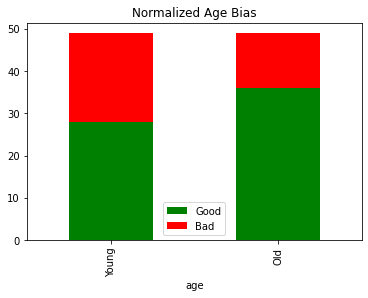

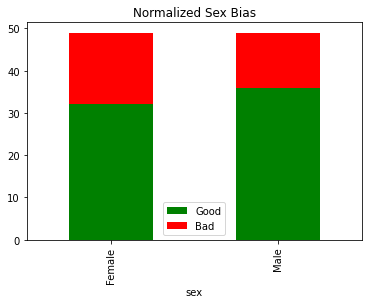

In [8]:
# non - normalized count
print('Non-normalized count:')
print(' ')
unnormalized_count_age = pd_gdata[['age', 'credit']].value_counts()
print(unnormalized_count_age)
unnormalized_count_sex = pd_gdata[['sex', 'credit']].value_counts()
print(unnormalized_count_sex)

# Age-credit distribution
print(' ')
print('Normalized Count:')
print(' ')
age_bias = getNormalizedCount(pd_gdata, 'age', 'credit')
print(age_bias)
# sex = 0 : Female
# sex = 1 : Male 
# credit = 1 : Good 
# credit = 2 : Bad 
# age = 0 : Young
# age = 1 : Old 

# ADD code here to print the SEX-CREDIT distribution
# male / female with good/bad credit. 
sex_bias = getNormalizedCount(pd_gdata, 'sex', 'credit')

print(sex_bias)

# ADD code here to visualise the results for both you can use stacked bar plots from pandas toolkit
#<your dataframe>.size().unstack().plot(kind='bar', stacked=True)
# print(pd_gdata['age'])

stack_age = age_bias.unstack().plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Normalized Age Bias')
plt.xticks([0,1], labels=['Young', 'Old'])
plt.legend(['Good', 'Bad'])


stack_sex = sex_bias.unstack().plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Normalized Sex Bias')
plt.xticks([0,1], labels=['Female', 'Male'])
plt.legend(['Good', 'Bad'])


There are biases in the data, there are more males than females with 'good' credit and more old than young people with 'good' credit. Whenever this data would be used as training data, this will lead to decisions being made on based on gender and age, whenever the credit is determined for a male, the chance of getting 'good' credit will be higher than for a female with the same conditions. The same holds for decisions based on age, an old person will be more likely to get good credit than a young person. And thus the resulting classification system will be discriminating towards females and towards young people. The system will thus be unfair. 

<br><br>

<H3> Step 4: In-Prosessing Biases </H3>

<b>Q6: We will apply in-processing mitigation technique to alliviate the <i>age</i> biase in the German credit data</b>

a) Set the privilege and unprivilaged age group based on the findings of question Q5-a (answer in the text then add the variables 0 or 1 to the code below). Provide a very brief justification for your answer


Privilaged group : Old, this group is more likely to get good credit. 

In [9]:
# Add the code for question a) here
# code = 1: is old above 25
# code = 0: is young under 25

privileged_code = 1 
unprivileged_code = 0 

In [10]:
# We start by defining the privilaged and unprivileged 
privileged_groups = [{'age': privileged_code}] 
unprivileged_groups = [{'age': unprivileged_code}] 

<b>Preparation for training a classifier.</b><br>
We will  divide the dataset into a training and a test subsets.
We define them respectively as 70% and 30% of the whole data.
We will use the following code to do so.

In [11]:
dataset_gcredit_train, dataset_gcredit_test = \
    dataset_gcredit.split([0.7], shuffle=True, seed=1)

<b>Faireness before mitigation</b><br>
Below we are using several faireness metrics from AIF360 toolkint to evaluate fairenesse metrics before appling the inprocessing mitigation

In [12]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_gcredit_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_orig_train.mean_difference()))

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.119


Get classifier without fairness constraints

In [13]:
biased_model = MetaFairClassifier(tau=0, sensitive_attr="sex", type="fdr").fit(dataset_gcredit_train)

Apply the unconstrained model to test data

In [14]:
dataset_bias_test = biased_model.predict(dataset_gcredit_test)

Build and test the "biased" classifier

In [15]:
classified_metric_bias_test = ClassificationMetric(dataset_gcredit_test, dataset_bias_test,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_bias_test.accuracy()))
TPR = classified_metric_bias_test.true_positive_rate()
TNR = classified_metric_bias_test.true_negative_rate()
bal_acc_bias_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_bias_test))
print("Test set: Disparate impact = {:.3f}".format(classified_metric_bias_test.disparate_impact()))
fdr = classified_metric_bias_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

Test set: Classification accuracy = 0.637
Test set: Balanced classification accuracy = 0.446
Test set: Disparate impact = 0.672
Test set: False discovery rate ratio = 0.649


<br>
<b> Q6 -</b>
b) Run the code above and explain the results: briefly describe each metric and the interpretation of the values.

Metrics:<br>
- Difference in mean outcomes between unprivileged and privileged groups: 
    <br> The offset between the mean of the priviliged and unpriviliged group, both means are a number between 0 and 1, according to the ratio of good/bad credits, for example if 50% of the privileged group will get a good credit than the mean will be 0.5. If the system would be fair, both groups would have the same mean, so the offset between the two means gives a indication of the bias in the training data. 
    The value of the difference in mean is -0.119, meaning that there is a bias (of about 12%) towards the priviliged group. 
  

- Classification accuracy:
    <br>This is a value to indicate how many of the made predictions were correct, to calculate this, the predicted values for the test set are compared to the known values for the test set. It is described by the following formula: 
<br> Accuracy = $\frac{(TP + TN)}{(TP + TN + FP + FN)} = \frac{correct predictions}{total number of predictions} $
    The accuracy is 0.634, this means that 63% of the predictions were done correctly. 

- Balanced classification accuracy:
    <br> In this case trainingset is adjusted to compensate for the imbalance of the number of measurements for each group. The amount of priviliged cases is made equal to the amount of unpriviliged cases and then the classification is done. The accuracy is calculated in the same way as described above.
    The balanced accuracy is 0.446, this means that 45% of the predictions were done correctly, this is about 18% less compared to the unbalanced accuracy. 
    
- Disparate impact:
    <br> This is a synonym for unintentional discrimination, this value shows the fraction of good credit prediction in the unpriviliged group vs the fraction of good credit prediction in the priviliged group. 
    The value for disparate impact is 0.672, this means that for 100 good credit predictions for the priviliged group, only 67 good credit predictions will be made for the unpriviliged group.

- False discovery rate ratio:
    <br> The false discovery rate (FDR) is the expected fraction of Type I errors. Type I errors are defined as the false positive, in this case a false positive is when someone incorrectly receives a good credit. The formula is as follows:
    <br> $\frac{False positives}{Total number of positives}$    
    The false discovery rate ratio is the ratio between the FDR for the unpriviliged and priviliged group.
    This formula is given by; 
    <br> $\frac{FDR_{unpriviliged}}{FDR_{priviliged}}$
    
    The value for 1 over the FDR ratio (1/FDR ratio) is 0.649, this means that the chance of finding a type I error is higher in the unpriviliged group compared to the priviliged group. 



<div class="alert alert-block alert-info">
<b> Tip: </b> Make use of the documentation of <a href=https://aif360.readthedocs.io/en/latest/index.html><b>AIF360</b></a>, and your own search to understaind the metrics and to be able to interpret them.
</div>

<b> Train a debiased classifier </b><br>
In the following we will apply an in-processing debiasin technique <b><i>"Meta-Algorithm for fair classification"</i></b>. This debiesing technique operates with a faireness constraint i.e., by optimising for faireness metrics. You can read more about it <a href=https://arxiv.org/pdf/1806.06055.pdf>[HERE]</a><br>
For this example we will to optimize for the <i><b> the fals discovery rate (fdr)</b></i> and sensitive attribute <i><b> age </b></i>
    
Apply the debiased model to training data and train the <b><i>"debiased"</i></b> classifier

In [16]:
debiased_model = MetaFairClassifier(tau=0.9, sensitive_attr="age", type="fdr", seed=10).fit(dataset_gcredit_train)

Apply the debiased classifier to test data

In [17]:
dataset_debiasing_test = debiased_model.predict(dataset_gcredit_test)

Compute the same faireness metrics for the <b><i>"debiased"</i></b> data and classifier

In [18]:
metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = {:.3f}".format(metric_dataset_debiasing_test.mean_difference()))

Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000


In [19]:
classified_metric_debiasing_test = ClassificationMetric(dataset_gcredit_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = {:.3f}".format(classified_metric_debiasing_test.accuracy()))
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_debiasing_test))
print("Test set: Disparate impact = {:.3f}".format(classified_metric_debiasing_test.disparate_impact()))
fdr = classified_metric_debiasing_test.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))


Test set: Classification accuracy = 0.713
Test set: Balanced classification accuracy = 0.500
Test set: Disparate impact = 1.000
Test set: False discovery rate ratio = 0.524


<br>
<b> Q6 -</b>
c) Run the code above and compare the results between the <b><i>"debiased"</i></b> and the <b><i>"biased"</i></b> classifiers


<div class="alert alert-block alert-info">
<b> Tip: </b> Focus on <b>FDR</b>, <b>Accuracy</b> and <b>Difference in mean outcomes</b>
</div>

The fairness penalty (tau) is a treshold for the system, when set to 1.0, it will try to achieve a totally fair system, however a result of this can be lower accuracy. In this case the value is set to 0.9 to get a more fair system but also maintaining accuracy. 
<br> The results are as followed. 

 
<table>
  <tr>
      <th></th>
    <th>Biased</th>
    <th>Debiased</th>
  </tr>
  <tr>
    <td>False discovery rate ratio (FDR ratio)</td>
    <td>0.649 </td>
    <td>0.524 </td>
  </tr>
  <tr>
      <td> Accuracy</td>
      <td> 0.637 </td>
      <td> 0.713 </td>
  </tr>
  <tr>
      <td> Difference in mean outcomes </td>
      <td> -0.119 </td>
      <td> 0.0 </td>
  </tr>
  
</table>

What can be concluded from the results above is that the chance for getting good credit is now equally as high for an old person as for a young person, this can be deducted from the fact that the difference in mean outcomes is 0.0. 
<br> There is no big difference in overall accuracy of the system, the debiased case is slightly more accurate with 71% compared to 64% for the biased system. 
<br> However, the FDR ratio has decreased to 0.524, which means that the imbalance between finding a Type I error for each group has increased. 

<br><br>

<H2> Part III. Explainability</H2>
<i>LO-4. Compare different implementations of fairness metrics and unfairness mitigation approaches.  
</i>

In this last part we will use the same scenario from Part II. To explore LIME Local Interpretable Model-Agnostic Explanations. 

In [20]:
#Train model on german credit data dataset

dataset = dataset_gcredit_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()        # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
lr_orig = model
lr_scale_orig = scale

In [21]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = lr_scale_orig

model = lr_orig                  #model to test
dataset = dataset_gcredit_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())

# print(bal_acc_arr)
# print(disp_imp_arr)
# print(avg_odds_diff_arr)

thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

# print(thresh_arr_best)
# print(disp_imp_at_best_bal_acc)
# print(avg_odds_diff_at_best_bal_acc)

100%|██████████| 50/50 [00:00<00:00, 297.85it/s]


In [22]:
limeData = LimeEncoder().fit(dataset_gcredit_train)
s_train = limeData.transform(dataset_gcredit_train.features)
s_test = limeData.transform(dataset_gcredit_test.features)

scale = lr_scale_orig

model = lr_orig                  #model to test




explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False, discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

<br>
<b>Q7: Using LIME </b> <br>
a) Provide a short definition of LIME and what it is used for. 

<div class="alert alert-block alert-info">
<b> Tip: </b> Information about LIME can be found <a href=https://arxiv.org/pdf/1602.04938.pdf> [HERE] </a>
</div>
    

- LIME is an explanation technique which can be used on any machine learning model. The explanation that LIME returns is based on a local exploration of the trained model around a single instance. That is, LIME learns how the trained model responses for various feature values around the one that is considered as input, and returns a form of explanation by using the features that are considered most important to reach the output of the trained model.
- LIME can therefore be used to provide an explanation of the features that are most likely to have lead to the output of the trained model. This results in an explanation that can be interpreted by humans, which allows them to give a better assessment of the obtained model output by using their specific knowledge in their field of expertise.

<b>Q7 - </b>
b) Select two loan applications form the test data set (One classified as "Good Credit" and one "Bad Credit"). Get the decision explaned by Lime. 

<div class="alert alert-block alert-info">
<b> Tip: </b>Use the following code to explain the classifier decision and print/plot the results from LIME

`i = # the index of the test data entry goes here
exp = explainer.explain_instance(s_test[i], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_gcredit_test.labels[i]))`

    
</div>

In [23]:
# Good Credit explanation
good_cred_bool = (dataset_gcredit_test.labels == 1.0).flatten()     # good credit
good_cred_ind  = [i for i, x in enumerate(good_cred_bool) if x]

i = good_cred_ind[6] # the index of the test data entry goes here
i = good_cred_ind[16] # the index of the test data entry goes here
exp = explainer.explain_instance(s_test[i], s_predict_fn, num_features=8)

print(f'Actual label: {dataset_gcredit_test.labels[i][0]}')

exp.show_in_notebook()
# exp.as_pyplot_figure()


Actual label: 1.0


Above figures show the LIME output for a test case with true label 1.0 (good credit) while the model predicted the instance to be a bad credit. 

The figure on the left shows the probability distribution of the output. Here it becomes clear that the model predicts a bad credit with a probability of 64%, and a good credit with a probability of 35%. Since the case actual turned out to be a good credit, it is interesting to see what the most important features are that resulted in this (false) output. This is where LIME becomes useful.

The center figure displays the features that describe the model output, ordered in feature importance. It can be seen that each feature contributes to either the good credit probability, or the bad credit probability. The value corresponding to each feature describes the predicted average increase in good/bad probability if that feature would be different than its current value.

For the considered case, an important feature is seen to be the 'credit_history' which is equal to Other. Looking at the corresponding value of 0.13, it is expected that the bad probability would, on average, be reduced to 51%, if the person in question would have a different credit hostory recording. Something can also be said about the age of the person in question. On the right figure, it can be seen that the person in question belongs to the 'old' age category. From the LIME output, it can be seen that this resulted in a contribution to the good credit probability of 0.09%.

By considering several of these features together with their importance as computed by LIME, each individual case can be assessed by a human employee. He/She can use this description to construct a case specific trade-off to ensure that the probability of a good credit is increased to a better value. 

In [24]:
# Bad Credit explanation
bad_cred_bool = (dataset_gcredit_test.labels == 2.0).flatten()     # bad credit
bad_cred_ind  = [i for i, x in enumerate(bad_cred_bool) if x]

i = bad_cred_ind[1] # the index of the test data entry goes here
exp = explainer.explain_instance(s_test[i], s_predict_fn, num_features=8)

print(f'Actual label: {dataset_gcredit_test.labels[i][0]}')

exp.show_in_notebook()
# exp.as_pyplot_figure()


Actual label: 2.0


Above figures show the LIME output for a test case with true label 2.0 (bad credit), and where the predicted label also turned out to be 2.0 (bad credit).

Similar to the answer provided for the good credit, the explanation of LIME can be seen in the center figure. Here it becomes clear that the most important feature that contributes to the bad credit probability was the duration of the loane, which is equal to 12 months. Besides the duration of the loane, other contributing features of the considered case are:

    - the number of liable people
    - the number of credits
    - the length of the client's employment

It should be noted that LIME constructs their explanations by locally examing the trained model. It can therefore not be concluded that the relations as shown in the center figure, are valid on a global scale across the model. That is, for a different combination of input features, e.g. the 'employment' feature could contribute to a good credit. Every instance should therefore be investigated seperately by LIME, from which these relations can be drawn.

<b>Q7 - </b>
c) Describe and explaine the results from lime for each of the decisions (Output of Q7-b)

See descriptions above.

<H3> --------- And of the assignment ---------</H3><br>
<i>We hope that you enjoyed this lecture.<br> Nadia & Ibo